In [25]:
import os
os.chdir('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/notebooks/TEST_FINALS/')
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
from jax import vmap, grad
from jax_cosmo import Cosmology
from functools import partial
from jax_cosmo.power import linear_matter_power
from jax_cosmo.background import angular_diameter_distance, radial_comoving_distance
import jax_cosmo.transfer as tklib
import astropy.units as u
from astropy import constants as const
RHO_CRIT_0_MPC3 = 2.77536627245708E11
G_new = ((const.G * (u.M_sun / u.Mpc**3) * (u.M_sun) / (u.Mpc)).to(u.eV / u.cm**3)).value
import constants
import jax_cosmo.background as bkgrd
import jax_cosmo.transfer as tklib
from jax_cosmo.scipy.integrate import romb
from jax_cosmo.scipy.integrate import simps
from jax_cosmo.scipy.interpolate import interp
from mcfit import xi2P
from colossus.halo import mass_so
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
class HMF_jax:
    def __init__(
                self,
                sim_params_dict,
                halo_params_dict,
                num_points_trapz_int=64
            ):    
        
        self.cosmo_params = sim_params_dict['cosmo']

        self.cosmo_jax = Cosmology(
            Omega_c=self.cosmo_params['Om0'] - self.cosmo_params['Ob0'],
            Omega_b=self.cosmo_params['Ob0'],
            h=self.cosmo_params['H0'] / 100.,
            sigma8=self.cosmo_params['sigma8'],
            n_s=self.cosmo_params['ns'],
            Omega_k=0.,
            w0=self.cosmo_params['w0'],
            wa=0.
            )

        zmin, zmax, nz = halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz']
        Mmin, Mmax, nM = halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM']
        dmin, dmax, nd = halo_params_dict['dmin'], halo_params_dict['dmax'], halo_params_dict['nd']
        self.Rcond = halo_params_dict['Rcond']
        self.z_array = jnp.linspace(zmin, zmax, nz)
        self.M_array = jnp.logspace(np.log10(Mmin), np.log10(Mmax), nM)
        self.deltam_array = jnp.exp(jnp.linspace(jnp.log(1+dmin+1e-3), jnp.log(1+dmax+1e-3), nd)) - 1.0
        mdef = halo_params_dict['mdef']
        r200c_mat = np.zeros((len(self.M_array), len(self.z_array)))
        for jz in range(len(self.z_array)):
            r200c_mat[:, jz] = (mass_so.M_to_R(self.M_array, self.z_array[jz], mdef) / (1000.))

        self.r200c_mat = jnp.array(r200c_mat)

        self.scale_fac_a_array = 1./(1. + self.z_array)
        self.nM, self.nz, self.nd = len(self.M_array), len(self.z_array), len(self.deltam_array)


        self.kPk_array = jnp.logspace(jnp.log10(1E-3), jnp.log10(100), 100)
        self.plin_kz_mat = vmap(linear_matter_power,(None, None, 0))(self.cosmo_jax, self.kPk_array, self.scale_fac_a_array).T

        rhom_z_array = (constants.RHO_CRIT_0_KPC3 * self.cosmo_params['Om0'] * (1.0 + self.z_array)**3) * 1E9
        rhom_z_mat = jnp.repeat(rhom_z_array[:, None], self.nM, axis=1)
        M_z_mat = jnp.repeat(self.M_array[None,:], self.nz, axis=0)

        rhom_z_delta_mat = jnp.repeat(rhom_z_mat[:,:, None], self.nd, axis=2)
        M_z_delta_mat = jnp.repeat(M_z_mat[:,:, None], self.nd, axis=2)


        vmap_func1 = vmap(self.get_lgsigma_z, (0, None))
        vmap_func2 = vmap(vmap_func1, (None, 0))
        lgsigma_Mz_mat = vmap_func2(self.z_array, jnp.log(self.M_array)).T
        self.sigma_Mz_mat = jnp.exp(lgsigma_Mz_mat)

        grad_lgsigma = grad(self.get_lgsigma_z, argnums=1)
        vmap_func1 = vmap(grad_lgsigma, (0, None))
        vmap_func2 = vmap(vmap_func1, (None, 0))
        self.dlgsig_dlnM_mat = vmap_func2(self.z_array, jnp.log(self.M_array)).T

        vmap_func1 = vmap(self.get_fsigma_Mz, (0, None))
        vmap_func2 = vmap(vmap_func1, (None, 0))
        self.fsigma_Mz_mat = vmap_func2(jnp.arange(self.nz), jnp.arange(self.nM)).T

        self.hmf_Mz_mat = -1 * self.fsigma_Mz_mat * (rhom_z_mat/M_z_mat) * self.dlgsig_dlnM_mat


        vmap_func1 = vmap(self.get_lgsigmaprime_z, (0, None, None))
        vmap_func2 = vmap(vmap_func1, (None, 0, None))
        vmap_func3 = vmap(vmap_func2, (None, None, 0))        
        lgsigma_Mzdeltam_mat = vmap_func3(self.z_array, jnp.log(self.M_array), self.deltam_array).T
        self.sigma_Mzdeltam_mat = jnp.exp(lgsigma_Mzdeltam_mat)

        grad_lgsigmadeltam = grad(self.get_lgsigmaprime_z, argnums=1)
        vmap_func1 = vmap(grad_lgsigmadeltam, (0, None, None))
        vmap_func2 = vmap(vmap_func1, (None, 0, None))
        vmap_func3 = vmap(vmap_func2, (None, None, 0))        
        self.dlgsig_dlnM_deltam_mat = vmap_func3(self.z_array, jnp.log(self.M_array), self.deltam_array).T

        vmap_func1 = vmap(self.get_fsigma_Mzdeltam, (0, None, None))
        vmap_func2 = vmap(vmap_func1, (None, 0, None))
        vmap_func3 = vmap(vmap_func2, (None, None, 0))        
        self.fsigma_Mzdeltam_mat = vmap_func3(jnp.arange(self.nz), jnp.arange(self.nM), jnp.arange(self.nd)).T

        self.hmf_Mzdeltam_mat = -1 * self.fsigma_Mzdeltam_mat * (rhom_z_delta_mat/M_z_delta_mat) * self.dlgsig_dlnM_deltam_mat


        
    def get_rho_m(self, z):
        return (constants.RHO_CRIT_0_KPC3 * self.cosmo_params['Om0'] * (1.0 + z)**3) * 1E9

    def get_Ez(self, z):
        zp1 = (1.0 + z)
        t = (self.cosmo_params['Om0']) * zp1**3 + (1 - self.cosmo_params['Om0'])
        E = jnp.sqrt(t)        
        return E

    def get_rho_c(self, z):
        return constants.RHO_CRIT_0_KPC3 * self.get_Ez(z)**2  * 1E9      

    @partial(jit, static_argnums=(0,))        
    def get_lgsigma_z(self, z, lgM, kmin=0.0001, kmax=1000.0):
        M = jnp.exp(lgM)
        R = (3.0 * M / 4.0 / jnp.pi / self.get_rho_m(0.0))**(1.0 / 3.0)

        jz = jnp.searchsorted(self.z_array, z)

        def int_sigma(logk):
            k = jnp.exp(logk)
            x = k * R
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        return jnp.log(jnp.sqrt(y / (2.0 * jnp.pi**2.0)))
        
    @partial(jit, static_argnums=(0,))        
    def get_lgsigma_l_z(self, z, lgM, kmin=0.0001, kmax=1000.0):
        M = jnp.exp(lgM)
        R = (3.0 * M / 4.0 / jnp.pi / self.get_rho_m(0.0))**(1.0 / 3.0)

        jz = jnp.searchsorted(self.z_array, z)

        def int_sigma(logk):
            k = jnp.exp(logk)
            x = k * self.Rcond
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        return jnp.log(jnp.sqrt(y / (2.0 * jnp.pi**2.0)))


    @partial(jit, static_argnums=(0,))        
    def get_lgsigmaprime_z(self, z, lgM, delta_m, kmin=0.0001, kmax=1000.0):

        jz = jnp.searchsorted(self.z_array, z) 

        M = jnp.exp(lgM)
        R_M = (3.0 * M / 4.0 / jnp.pi / self.get_rho_m(0.0))**(1.0 / 3.0)
        def int_sigma_M(logk):
            k = jnp.exp(logk)
            x = k * R_M
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma_M, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        sigma_sqr = jnp.sqrt(y / (2.0 * jnp.pi**2.0))

        def int_sigma_cond(logk):
            k = jnp.exp(logk)
            x = k * self.Rcond
            w = 3.0 * (jnp.sin(x) - x * jnp.cos(x)) / (x * x * x)
            pkz = jnp.exp(jnp.interp(logk, jnp.log(self.kPk_array), jnp.log(self.plin_kz_mat[:, jz])))
            return k * (k * w) ** 2 * pkz

        y = romb(int_sigma_cond, jnp.log10(kmin), jnp.log10(kmax), divmax=7)
        sigma_l_sqr = jnp.sqrt(y / (2.0 * jnp.pi**2.0))

        delta_c = constants.DELTA_COLLAPSE

        delta_l = (delta_c/1.68647) * (1.68647 - (1.35/((1 + delta_m)**(2/3))) - 1.12431/((1 + delta_m)**(0.5)) + 0.78785/((1 + delta_m)**0.58661))

        sigma_prime_sqr = (sigma_sqr - sigma_l_sqr) * (delta_c/(delta_c - delta_l))**2
        # sigma_prime_sqr = (sigma_sqr - sigma_l_sqr)

        return jnp.log(jnp.sqrt(sigma_prime_sqr))

    @partial(jit, static_argnums=(0,))
    def get_fsigma_Mz(self, jz, jM, mdef_delta=200):
        '''Tinker 2008 mass function'''
        sigma = self.sigma_Mz_mat[jz, jM]
        z = self.z_array[jz]
        rho_treshold = mdef_delta * self.get_rho_c(z)
        Delta_m = round(rho_treshold / self.get_rho_m(z))

        fit_Delta = jnp.array([200, 300, 400, 600, 800, 1200, 1600, 2400, 3200])
        fit_A0 = jnp.array([0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
        fit_a0 = jnp.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
        fit_b0 = jnp.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
        fit_c0 = jnp.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])
            
        
        A0 = jnp.interp(Delta_m, fit_Delta, fit_A0)
        a0 = jnp.interp(Delta_m, fit_Delta, fit_a0)
        b0 = jnp.interp(Delta_m, fit_Delta, fit_b0)
        c0 = jnp.interp(Delta_m, fit_Delta, fit_c0)
        
        alpha = 10**(-(0.75 / jnp.log10(Delta_m / 75.0))**1.2)
        A = A0 * (1.0 + z)**-0.14
        a = a0 * (1.0 + z)**-0.06
        b = b0 * (1.0 + z)**-alpha
        c = c0
        f = A * ((sigma / b)**-a + 1.0) * jnp.exp(-c / sigma**2)
        
        return f


    @partial(jit, static_argnums=(0,))
    def get_fsigma_Mzdeltam(self, jz, jM, jd, mdef_delta=200):
        '''Tinker 2008 mass function'''
        sigma = self.sigma_Mzdeltam_mat[jz, jM, jd]
        z = self.z_array[jz]
        rho_treshold = mdef_delta * self.get_rho_c(z)
        Delta_m = round(rho_treshold / self.get_rho_m(z))

        fit_Delta = jnp.array([200, 300, 400, 600, 800, 1200, 1600, 2400, 3200])
        fit_A0 = jnp.array([0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
        fit_a0 = jnp.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
        fit_b0 = jnp.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
        fit_c0 = jnp.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])
            
        
        A0 = jnp.interp(Delta_m, fit_Delta, fit_A0)
        a0 = jnp.interp(Delta_m, fit_Delta, fit_a0)
        b0 = jnp.interp(Delta_m, fit_Delta, fit_b0)
        c0 = jnp.interp(Delta_m, fit_Delta, fit_c0)
        
        alpha = 10**(-(0.75 / jnp.log10(Delta_m / 75.0))**1.2)
        A = A0 * (1.0 + z)**-0.14
        a = a0 * (1.0 + z)**-0.06
        b = b0 * (1.0 + z)**-alpha
        c = c0
        f = A * ((sigma / b)**-a + 1.0) * jnp.exp(-c / sigma**2)
        
        return f





In [64]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['cosmo'] = cosmo_params_dict

halo_params_dict = {}
halo_params_dict['dmin'], halo_params_dict['dmax'], halo_params_dict['nd'] = -1.0, 10, 16
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0, 0.5, 2
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e13, 1e15, 17
halo_params_dict['mdef'] = '200c'
halo_params_dict['Rcond'] = 20.0





In [65]:
%%time
HMF_jax_test = HMF_jax(sim_params_dict, halo_params_dict)





CPU times: user 53.5 s, sys: 3.98 s, total: 57.5 s
Wall time: 15.7 s


In [66]:
dndm_jax = HMF_jax_test.hmf_Mz_mat
dndm_cond_jax = HMF_jax_test.hmf_Mzdeltam_mat





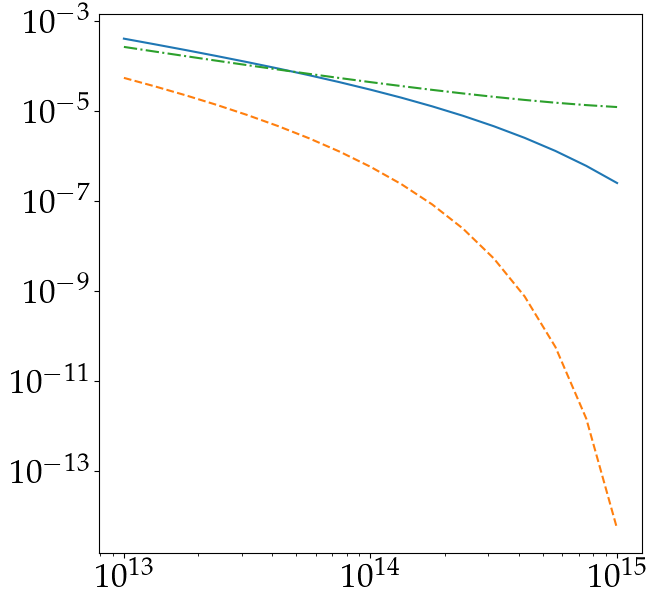

In [68]:
# dndm_jax.shape
pl.figure()
pl.plot(HMF_jax_test.M_array, dndm_jax[0,:])
pl.plot(HMF_jax_test.M_array, dndm_cond_jax[0,:,10], ls='--')
pl.plot(HMF_jax_test.M_array, dndm_cond_jax[0,:,15], ls='-.')
pl.xscale('log')
pl.yscale('log')





In [62]:
dndm_cond_jax[0,:,5]

Array([2.01838956e-04, 1.48923777e-04, 1.09081416e-04, 7.90761385e-05,
       5.66830873e-05, 4.00096863e-05, 2.77169181e-05, 1.87472404e-05,
       1.22929011e-05, 7.74270960e-06, 4.60928892e-06, 2.54316764e-06,
       1.25602295e-06, 5.27117648e-07, 1.71067190e-07, 3.60897737e-08,
       3.41660733e-09], dtype=float64)

In [51]:
sigmaMz_jax = HMF_jax_test.sigma_Mz_mat
sigmaMz_cond_jax = HMF_jax_test.sigma_Mzdeltam_mat





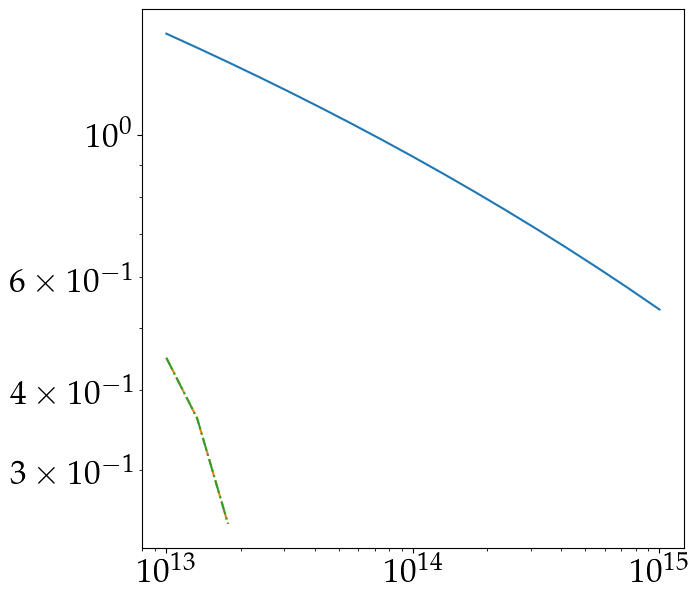

In [52]:
# dndm_jax.shape
pl.figure()
pl.plot(HMF_jax_test.M_array, sigmaMz_jax[0,:])
pl.plot(HMF_jax_test.M_array, sigmaMz_cond_jax[0,:,10], ls='--')
pl.plot(HMF_jax_test.M_array, sigmaMz_cond_jax[0,:,15], ls='-.')
pl.xscale('log')
pl.yscale('log')





In [53]:
sigmaMz_cond_jax[0,:,10]

Array([0.44893972, 0.3610386 , 0.24702335,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan], dtype=float64)